# Forecasting Sales in a Bakery: A Data Science Example
**Scenario:**

Imagine a bakery asking us to perform an analysis and forecast of their sales over the course of a year, as well as a prediction for the upcoming week. In many small and medium-sized businesses, the best-selling products are usually intuitive. However, to make an effective TotalDailySales sales forecast, it is essential to have concrete data.

In this hypothetical case, we connect to a database that contains sales data from the past year. We will conduct exploratory data analysis and build an autoregressive machine learning model using skforecast to predict sales for the upcoming week.

**Requirements:**

* sqlite3: To connect to and query the database.

* pandas: To manipulate and analyze the data.

* seaborn: For data visualization.

* matplotlib: To generate graphs and visualizations.

* scikit-learn: For machine learning techniques.

* skforecast: To build the autoregressive model.

* lightGBM: For boosting algorithms.

## First: Collect data

In [13]:
import sqlite3
import pandas as pd
conn = sqlite3.connect('bakery_sales.db')
data = pd.read_sql_query(
    "SELECT * FROM bakery_sales", 
    conn, 
    index_col='ID', 
    dtype={'ID':int,'ticket_number': int, 'Quantity': int, 'datetime': str, 'unit_price_euro': float}
)
conn.close()
data['datetime'] = pd.to_datetime(data['datetime'])
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 234005 entries, 0 to 511395
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   ticket_number    234005 non-null  int32         
 1   article          234005 non-null  object        
 2   Quantity         234005 non-null  int32         
 3   datetime         234005 non-null  datetime64[ns]
 4   unit_price_euro  234005 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int32(2), object(1)
memory usage: 8.0+ MB
None


In [14]:
data['date'] = data['datetime'].dt.date
data['time'] = data['datetime'].dt.time
data['hour'] = data['datetime'].dt.hour
data['year'] = data['datetime'].dt.year
data['weekday'] = data['datetime'].dt.weekday
data['month'] = data['datetime'].dt.month

TotalDaysWorked = len(data['date'].unique())
print('Days w/sales:', TotalDaysWorked)
data

Days w/sales: 600


,ticket_number,article,Quantity,datetime,unit_price_euro,date,time,hour,year,weekday,month
ID,,,,,,,,,,,
0,150040,BAGUETTE,1,2021-01-02 08:38:00,0.90,2021-01-02,08:38:00,8,2021,5,1
1,150040,PAIN AU CHOCOLAT,3,2021-01-02 08:38:00,1.20,2021-01-02,08:38:00,8,2021,5,1
4,150041,PAIN AU CHOCOLAT,2,2021-01-02 09:14:00,1.20,2021-01-02,09:14:00,9,2021,5,1
5,150041,PAIN,1,2021-01-02 09:14:00,1.15,2021-01-02,09:14:00,9,2021,5,1
8,150042,TRADITIONAL BAGUETTE,5,2021-01-02 09:25:00,1.20,2021-01-02,09:25:00,9,2021,5,1
...,...,...,...,...,...,...,...,...,...,...,...
511387,288911,COUPE,1,2022-09-30 18:52:00,0.15,2022-09-30,18:52:00,18,2022,4,9
511388,288911,BOULE 200G,1,2022-09-30 18:52:00,1.20,2022-09-30,18:52:00,18,2022,4,9
511389,288911,COUPE,2,2022-09-30 18:52:00,0.15,2022-09-30,18:52:00,18,2022,4,9


## Sales by day, month, hour

In the following charts, total sales are grouped by day of the week.

The data shows that total sales are higher on non-working days (Saturday and Sunday), while the day with the lowest sales is Wednesday. Additionally, the seasons with the highest sales are spring and summer, which are warmer and possibly rainier.

Analyzing sales by hours, we observe that there are more sales during working hours. There are practically no sales between 2:00 PM and 5:00 PM, suggesting that the establishment might be closed during these hours. After this period, there is a small time window with low sales.

Note: The causes may vary depending on the establishment.

Text(-12.430555555555555, 0.5, 'Sales count')

<Figure size 640x480 with 0 Axes>

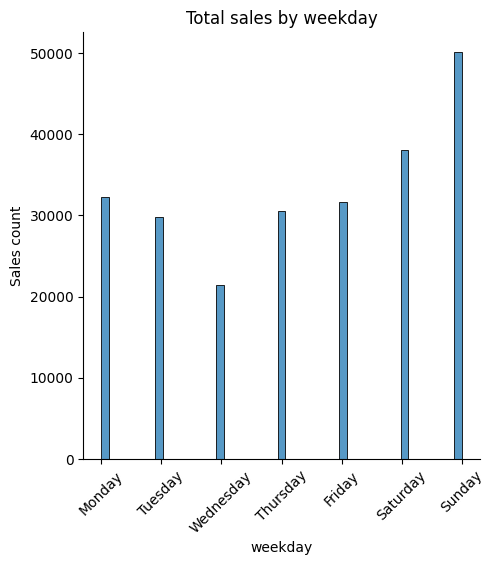

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure()
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.displot(data['weekday'])
plt.xticks(ticks=range(len(weekday_names)), labels=weekday_names, rotation=45)
plt.title('Total sales by weekday')
plt.ylabel('Sales count')

Text(-12.430555555555555, 0.5, 'Sales Count')

<Figure size 640x480 with 0 Axes>

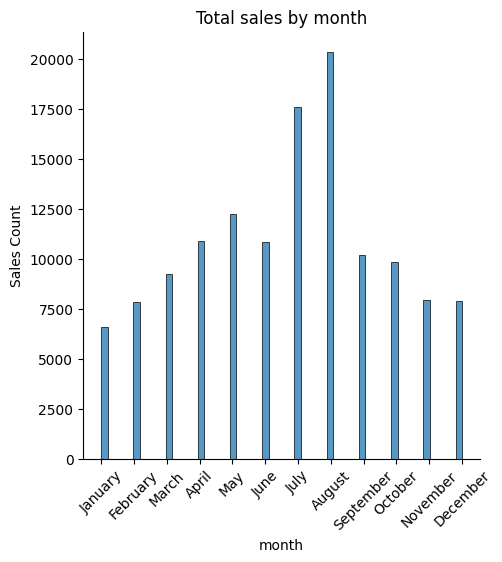

In [16]:
plt.figure()
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
sns.displot(data[data['datetime']<'2022-01-01'].loc[:,'month'])
plt.xticks(ticks=range(1, 13), labels=month_names, rotation=45)
plt.title('Total sales by month')
plt.ylabel('Sales Count')

Text(-12.430555555555555, 0.5, 'Sales count')

<Figure size 640x480 with 0 Axes>

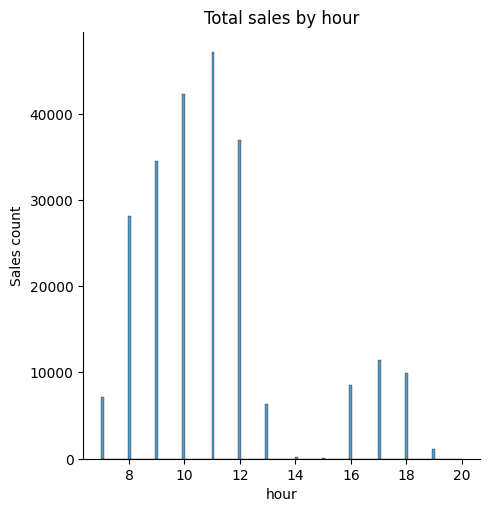

In [17]:
plt.figure()
sns.displot(data['hour'])
plt.title('Total sales by hour')
plt.ylabel('Sales count')

## Sales by Product

In the following charts, we can see the top 15 best-selling items. It is clear that the star product of this business is the traditional baguette, followed by items like the croissant, pain au chocolat, coupe, bannete, and baguette.

Moreover, while most products peak in sales on Saturdays and Sundays, there are certain products that are sold exclusively on working days, such as the formule sandwich.


Text(0.5, 1.0, 'Average sales of the most selled products along the week')

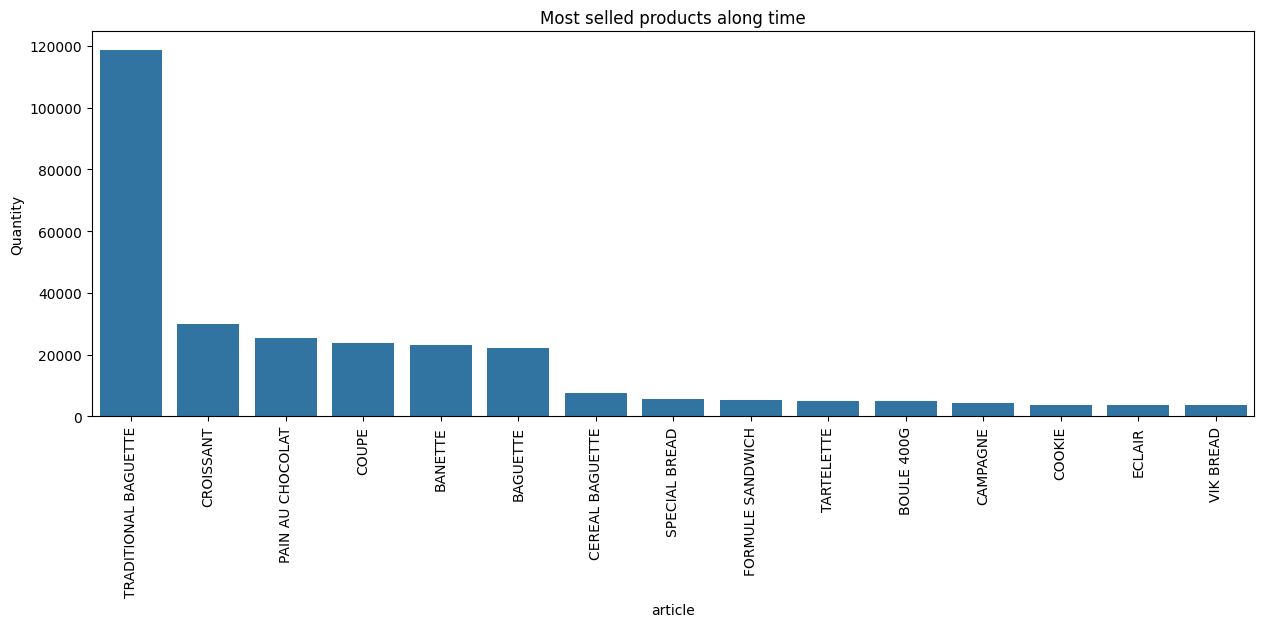

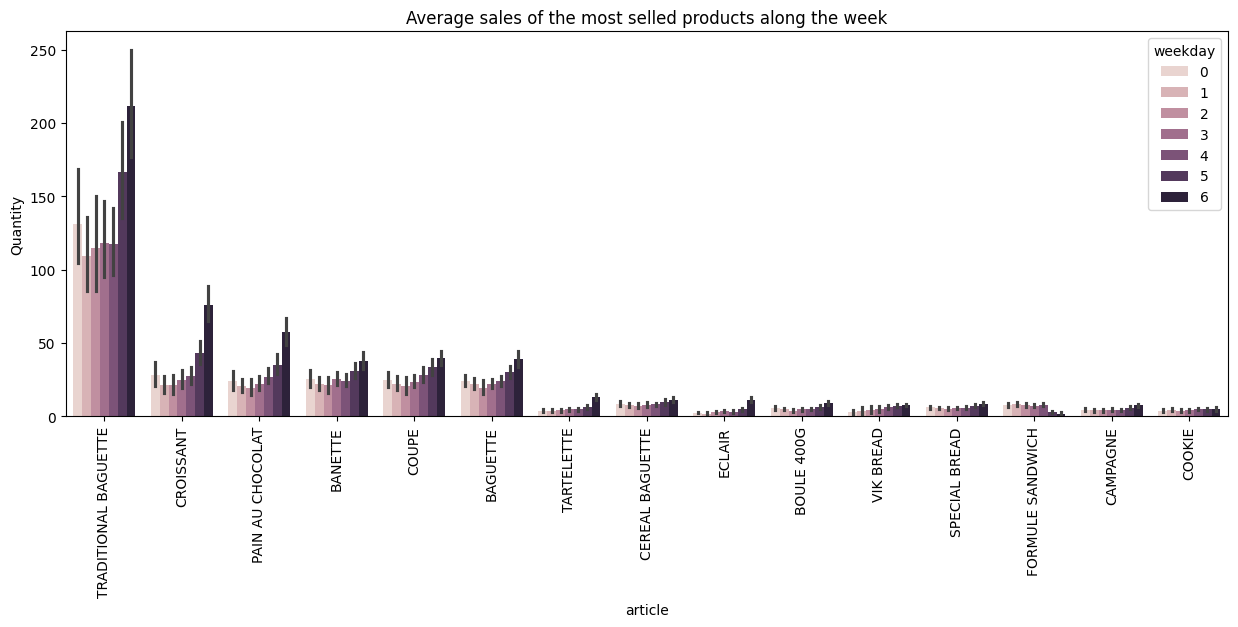

In [ ]:
SalesByTime = data.groupby(['article','year','month','weekday'])['Quantity'].sum().sort_values(ascending=False).reset_index()
PiecesByTime = data.groupby('article')['Quantity'].sum().sort_values(ascending=False).reset_index() # total pieces selled by article

MostSelledProducts = PiecesByTime[PiecesByTime['Quantity']>3600].loc[:,'article']

plt.figure(figsize=(15,5))
sns.barplot(x='article', y='Quantity', data=PiecesByTime[PiecesByTime['article'].isin(MostSelledProducts)])
plt.xticks(rotation=90)
plt.title('Most selled products along SalesDatetime')

plt.figure(figsize=(15,5))
SalesByTime['Quantity'] /= 6 # six days of work in average
sns.barplot(x='article', y='Quantity', data=SalesByTime[SalesByTime['article'].isin(MostSelledProducts)], hue='weekday')
plt.xticks(rotation=90)
plt.title('Average sales of the most selled products along the week')

## Daily Sales and Correlation

From the following interactive charts of daily sales and sales correlation, we can deduce the following:

* The products with the highest variation in absolute sales by season are: traditional baguette, croissant, pain au chocolat, coupe, bannete, and baguette.
* The sales quantity of the less sold items is more constant over time.
* There are groups of items that tend to sell well together (Boule 400g-Coupe, Champagne-Coupe, Croissant-Pain au chocolat, Coupe-Vik bread).
* There are groups of items that have a negative sales correlation (if one is purchased, it is quite likely that the other will not be sold). These are the Traditional Baguette paired with: baguette, banette, coupe, cereal baguette, formule sandwich.

The correlations can help us make recommendations to customers who purchase any of the described items.

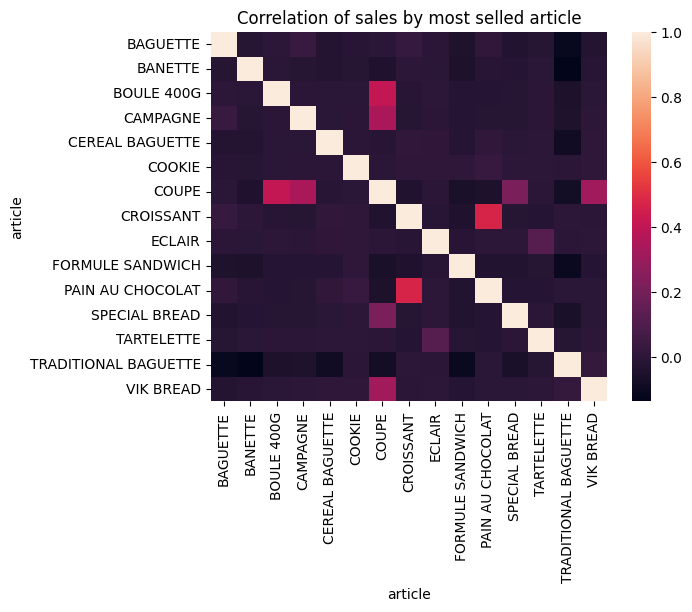

In [22]:
TotalDailySales = data.groupby(['date', 'article'])['Quantity'].sum().reset_index() 
SalesDatetime = data.groupby(['datetime', 'article'])['Quantity'].sum().reset_index() 
TotalDailySales['date'] = pd.to_datetime(TotalDailySales['date'])

# Filtering to show just the most selled articles
TotalDailySales = TotalDailySales[TotalDailySales['article'].isin(MostSelledProducts)] 
SalesDatetime = SalesDatetime[SalesDatetime['article'].isin(MostSelledProducts)]

TotalDailySales = TotalDailySales.pivot(index='date', columns='article', values='Quantity').fillna(0)
SalesDatetime = SalesDatetime.pivot(index='datetime', columns='article', values='Quantity').fillna(0)

TotalDailySales = TotalDailySales.asfreq('D').fillna(0)

# Show the relation of the sales by article
plt.figure()
sns.heatmap(SalesDatetime.corr())
plt.title('Correlation of sales by most selled article')

# Show the interactive plotly plot of the sales along the SalesDatetime
import plotly.graph_objects as go

fig = go.Figure()
for column in TotalDailySales.columns:
    fig.add_trace(go.Scatter(x=TotalDailySales.index, y=TotalDailySales[column], mode='lines', name=column))

fig.update_layout(
    title='Daily sales of most selled articles',
    xaxis_title='Date',
    yaxis_title='Quantity Sold',
    legend_title='Article'
)

fig.show()

## Forecasting

Forecasting is performed using a multiseries recursive model, which allows us to make predictions for all sales using a single model.

As an evaluation metric, we use the mean absolute error because we are not particularly concerned with outliers in this specific case; our focus is on achieving a good average prediction. We have relatively low errors, averaging about 6 pieces of bread per day, which is quite a good prediction for the bakery's sales volume.


In [23]:
from lightgbm import LGBMRegressor
from skforecast.preprocessing import RollingFeatures
from skforecast.recursive import ForecasterRecursiveMultiSeries

# train test split
train_data = TotalDailySales.iloc[:-7].copy()
validation_data = TotalDailySales.iloc[-7:].copy() # last week for validation

# ML model
forecaster = ForecasterRecursiveMultiSeries(
    regressor=LGBMRegressor(random_state=21, verbose = -1),
    lags = 30,
    window_features=RollingFeatures(
        stats=['mean','mean'],
        window_sizes=[7, 30]
    )
)

forecaster.fit(series=TotalDailySales)

c:\Users\guill\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



### Backtesting

Backtesting is a validation technique used primarily in time series forecasting and financial modeling. It involves testing a predictive model on historical data to evaluate its performance in real-world scenarios. By applying the model to past data and comparing the predicted outcomes with the actual results, backtesting allows us to assess the model's accuracy and reliability.

This technique is crucial in fields where the temporal order of data points matters, such as finance and sales forecasting. It helps in understanding how well the model would have performed in the past and can provide insights into its potential future performance.

To further evaluate the model's performance, we used the mean absolute error (MAE) as the evaluation metric. This choice was made because it emphasizes the average prediction accuracy without being overly influenced by outliers, which is particularly suitable for our forecasting needs. The resulting MAE values indicate that the model maintains a relatively low error rate, averaging about 6 pieces of bread per day. This level of accuracy is quite commendable given the bakery's sales volume.

In summary, backtesting is a method that uses historical data to simulate the performance of a predictive model, allowing for a realistic evaluation of its accuracy and robustness.


In [26]:
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_forecaster_multiseries

cv = TimeSeriesFold(steps = 7)

metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
    forecaster = forecaster,
    series = TotalDailySales,
    cv = cv,
    metric = 'mean_absolute_error',
    n_jobs = 'auto'
)

print("Backtest metrics:")
metrics_levels

100%|██████████| 87/87 [00:02<00:00, 32.83it/s]


Backtest metrics:


,levels,mean_absolute_error
0,BAGUETTE,8.415004
1,BANETTE,8.420774
2,BOULE 400G,3.208466
3,CAMPAGNE,2.823014
4,CEREAL BAGUETTE,4.550684
5,COOKIE,3.168128
6,COUPE,8.991353
7,CROISSANT,10.517446
8,ECLAIR,3.741828
9,FORMULE SANDWICH,3.803413


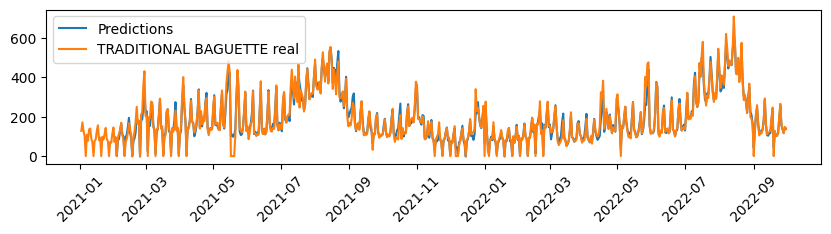

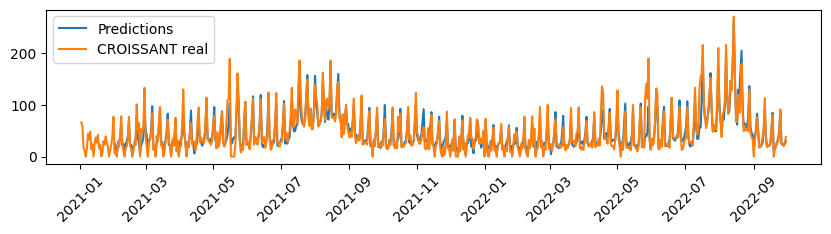

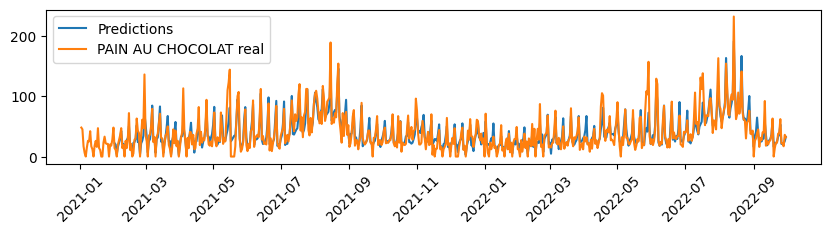

In [32]:
for col in MostSelledProducts[:3]:
    plt.figure(figsize=(10,2))
    plt.plot(backtest_predictions[col], label='Predictions')
    plt.plot(TotalDailySales[col], label = f'{col} real')
    plt.legend()
    plt.xticks(rotation = 45)
    plt.show()

### Validation of the Model

As we can see in the following three charts of the three most selled articles, the model predicts sales quite well within the 7-day time window we provided. The predictions closely follow the actual sales trends, demonstrating the model's effectiveness in capturing the underlying patterns of the data.

In conclusion, the model demonstrates strong predictive capabilities and provides valuable insights for the bakery's sales forecasting, making it a practical tool for future planning and decision-making.


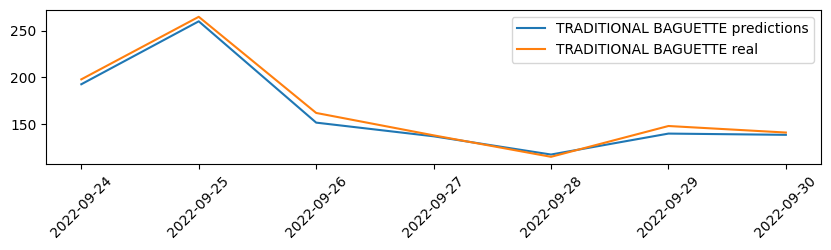

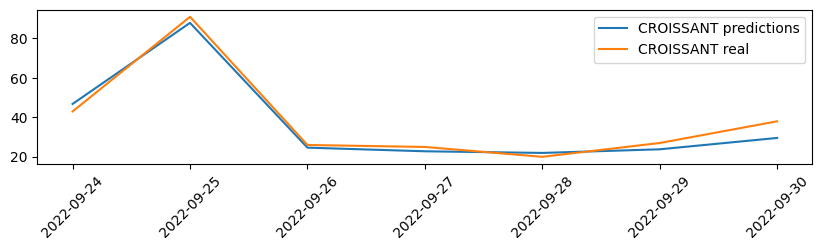

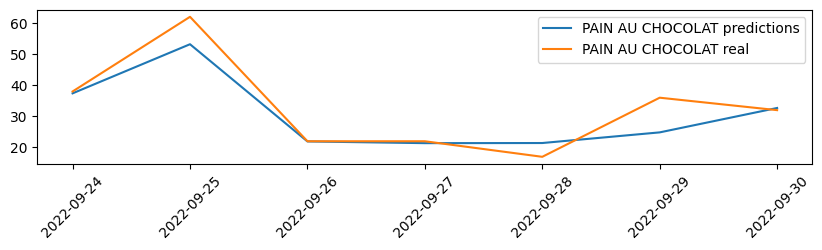

In [31]:
# validation probes
predictions = forecaster.predict(steps=7, last_window=train_data.iloc[-30:])
predictions = predictions

for col in MostSelledProducts[:3]:
    plt.figure(figsize=(10,2))
    plt.plot(predictions[col], label=f'{col} predictions')
    plt.plot(validation_data[col], label = f'{col} real')
    plt.xticks(rotation = 45)
    plt.legend()
    plt.show()